# Empirical Results for "Extending Conformal Prediction to Hidden Markov Models with Exact Validity via de Finetti’s Theorem for Markov Chains"

## This notebook contains the empirical results contained in Sec. 4.2 and the four datasets used:

### 1. SP500 Index 
### 2. Household Energy Consumption
### 3. Electricity Consumption in Delhi
### 4. Electricity Consumption in Punjab

## The proposed algorithm is implemented in the "Methods.py" file and is imported from there


In [1]:
# Importing the required packages

import numpy as np
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import bernoulli
from scipy.stats import pareto
import networkx as nx
import matplotlib.pyplot as plt
import random
import scipy.io
import collections
import pickle
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes,InsetPosition,mark_inset)
import copy
import itertools
import os.path
from os import path

In [2]:
# Importing the methods that implement the proposed frameowork

from Methods import *

# Empirical Results for the SP500 Index Dataset

In [3]:
# Importing Data

df = pd.read_csv('SPY.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Open - Close/Open,State,Observation
0,1/19/2022,458.130005,459.609985,451.459991,451.750000,444.538116,109357600,0.013926,1,NaN
1,1/20/2022,453.750000,458.739990,444.500000,446.750000,439.617920,122379700,0.015427,1,1.0
2,1/21/2022,445.559998,448.059998,437.950012,437.980011,430.987976,202271200,0.017012,1,1.0
3,1/24/2022,432.029999,440.380005,420.760010,439.839996,432.818237,251783900,-0.018077,0,1.0
4,1/25/2022,433.059998,439.720001,427.149994,434.470001,427.533997,167997300,-0.003256,0,0.0


Coverage = 0.8
Avg pred set size = 0.65


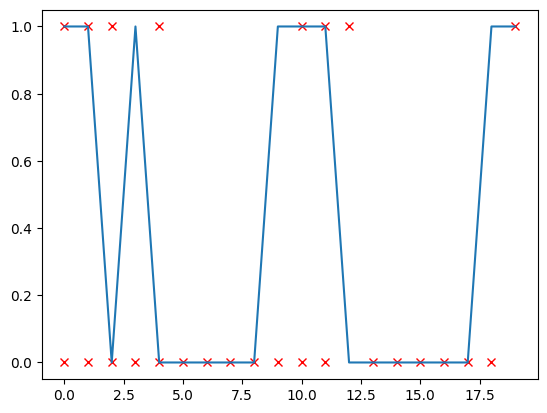

In [4]:
# Implementing the proposed frameowork
N = 100 #Number of times steps to be used as calibration (i.e., T1 in the proposed algorithm

True_count = 0
Pred_set_size_count = 0
ITER = 20 #Number of times steps to be used for evaluation. Setting it to 20 yields the last month of trading dates 12/20/2022 to 1/19/2023 (the dataset was obtained on 1/19/2023)

SPY_True_state_vec = []

SPY_PREDICTIONS = []
for t in np.arange(ITER):
    X=np.array([int(i) for i in df.State[1+t:N+t].tolist()])
    Y=np.array([int(i) for i in df.Observation[1+t:N+t].tolist()])
    X_pred = np.array([int(i) for i in df.State[N+t:N+t+1].tolist()])
    Y_pred = np.array([int(i) for i in df.Observation[N+t:N+t+1].tolist()])
    calX_LEN = 2
    calY_LEN = 2
    ALPHA = 0.8
    PERF = 0
    
    (True_state,pred_set) = CP_HMM_filtering(X, Y, X_pred, Y_pred, ALPHA, calX_LEN, calY_LEN, perf = PERF)
    SPY_True_state_vec.append(True_state)
    # print("True state = " + str(True_state))
    # print("Prediction Set = " + str(pred_set))    
    # print("")

    for pred in pred_set:
        plt.plot(t,pred, c='r', marker = 'x', markerfacecolor='none')
        SPY_PREDICTIONS.append((t,pred[0]))    
    
    True_count += (True_state in pred_set)
    Pred_set_size_count += len(pred_set)
    
plt.plot(SPY_True_state_vec)    
print("Coverage = " + str(True_count/len(np.arange(ITER))))
print("Avg pred set size = " + str((Pred_set_size_count/len(np.arange(ITER)))/2))

# Empirical Results for the Household Energy Consumption Dataset

In [33]:
# Importing the data

df = pd.read_csv('D202.csv')
df.head()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN


In [34]:
# Averaging the energy consumption for each day

df['DATE']= pd.to_datetime(df['DATE'])
df = pd.DataFrame(df.groupby(pd.PeriodIndex(df['DATE'], freq="D"))['USAGE'].mean())

In [35]:
# Creating discrete states that represent the energy consumption per day

df["State"] = np.nan
df["State"] = np.round((df["USAGE"] - df["USAGE"].mean())/ (df["USAGE"].std()))
min_val = df["State"].unique().min()
df["State"] -= min_val

In [36]:
# Number of states in the state space

df["State"].unique()
LEN = len(df["State"].unique())
print("State Space Cardinality = " + str(LEN))

State Space Cardinality = 7


In [37]:
df.head()

,USAGE,State
DATE,,
2016-10-22,0.047083,1.0
2016-10-23,0.242917,4.0
2016-10-24,0.074583,1.0
2016-10-25,0.090417,2.0
2016-10-26,0.052500,1.0


In [38]:
# Using the consumption at time t-1 as observation for time t

df["Observation"] = np.nan
for i in np.arange(len(df.index))-1:
    df.iloc[[i+1],[2]] = df.iloc[[i],[1]] 

In [39]:
df.head()

,USAGE,State,Observation
DATE,,,
2016-10-22,0.047083,1.0,1.0
2016-10-23,0.242917,4.0,1.0
2016-10-24,0.074583,1.0,4.0
2016-10-25,0.090417,2.0,1.0
2016-10-26,0.052500,1.0,2.0


Coverage = 0.7735849056603774
Avg pred set size = 0.22371967654986524


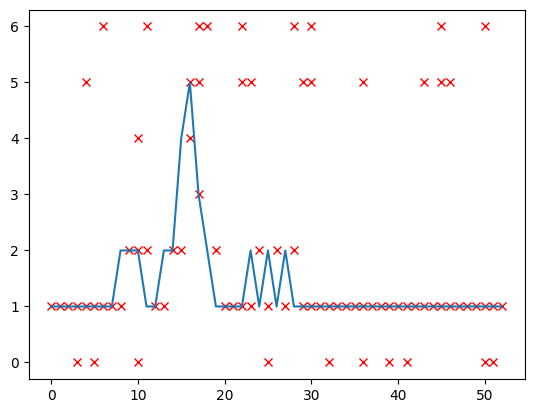

In [41]:
from Methods import *
N = 300 #Number of times steps to be used as calibration (i.e., T1 in the proposed algorithm

True_count = 0
Pred_set_size_count = 0
ITER = 53 #Number of times steps to be used for evaluation. The used value (53) corresponds to the last 2 months of data.

D202_True_state_vec = []

D202_PREDICTIONS = []
for t in np.arange(ITER):
    X=np.array([int(i) for i in df.State[1+t:N+t].tolist()])
    Y=np.array([int(i) for i in df.Observation[1+t:N+t].tolist()])
    X_pred = np.array([int(i) for i in df.State[N+t:N+t+1].tolist()])
    Y_pred = np.array([int(i) for i in df.Observation[N+t:N+t+1].tolist()])
    calX_LEN = 7
    calY_LEN = 7
    ALPHA = 0.8
    PERF = 0
    
    (True_state,pred_set) = CP_HMM_filtering(X, Y, X_pred, Y_pred, ALPHA, calX_LEN, calY_LEN, perf = PERF)
    D202_True_state_vec.append(True_state)

    for pred in pred_set:
        plt.plot(t,pred, c='r', marker = 'x', markerfacecolor='none')
        D202_PREDICTIONS.append((t,pred[0]))
        
    True_count += (True_state in pred_set)
    Pred_set_size_count += len(pred_set)
    
plt.plot(D202_True_state_vec)    
print("Coverage = " + str(True_count/len(np.arange(ITER))))
print("Avg pred set size = " + str((Pred_set_size_count/len(np.arange(ITER)))/calX_LEN))

# Empirical Results for Dataset of Electricity Consumption in Delhi 

In [42]:
# Importing the data
Location = "Delhi"

df = pd.read_csv('dataset_tk.csv')[['Unnamed: 0', Location]]
df.columns = ['Date', Location]
df.head()

,Date,Delhi
0,02/01/2019 00:00:00,85.8
1,03/01/2019 00:00:00,85.5
2,04/01/2019 00:00:00,83.5
3,05/01/2019 00:00:00,79.2
4,06/01/2019 00:00:00,76.6


In [43]:
# Setting the date column as index column
df.set_index("Date")
df.head()

,Date,Delhi
0,02/01/2019 00:00:00,85.8
1,03/01/2019 00:00:00,85.5
2,04/01/2019 00:00:00,83.5
3,05/01/2019 00:00:00,79.2
4,06/01/2019 00:00:00,76.6


In [44]:
# Creating discrete states that represent the energy consumption per day

df["State"] = np.nan
df["State"] = np.round((df[Location] - df[Location].mean())/ (df[Location].std()))
min_val = df["State"].unique().min()
df["State"] -= min_val


In [45]:
# Number of states in the state space

LEN = len(df["State"].unique())
print("State Space Cardinality = " + str(LEN))

State Space Cardinality = 5


In [46]:
# Using the consumption at time t-1 as observation for time t

df["Observation"] = np.nan
for i in np.arange(len(df.index))-1:
    df.iloc[[i+1],[-1]] = df.iloc[[i],[-2]] 
df.head()

,Date,Delhi,State,Observation
0,02/01/2019 00:00:00,85.8,2.0,2.0
1,03/01/2019 00:00:00,85.5,2.0,2.0
2,04/01/2019 00:00:00,83.5,2.0,2.0
3,05/01/2019 00:00:00,79.2,2.0,2.0
4,06/01/2019 00:00:00,76.6,2.0,2.0


Coverage = 0.8117647058823529
Avg pred set size = 0.2541176470588235


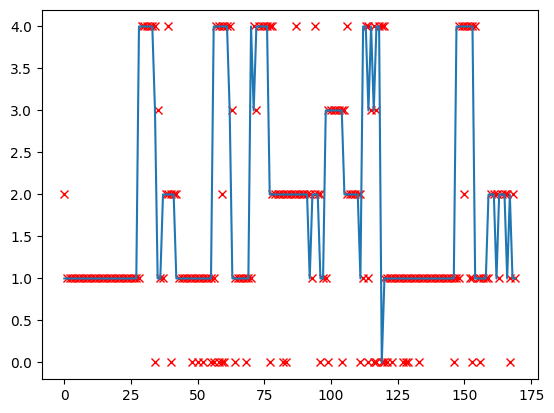

In [47]:
from Methods import *
N = 300

True_count = 0
Pred_set_size_count = 0
ITER = 170 #Setting it to 170 for yields the last 6 months predictions

Delhi_True_state_vec = []

Delhi_PREDICTIONS = []
for t in np.arange(ITER):
    X=np.array([int(i) for i in df.State[1+t:N+t].tolist()])
    Y=np.array([int(i) for i in df.Observation[1+t:N+t].tolist()])
    X_pred = np.array([int(i) for i in df.State[N+t:N+t+1].tolist()])
    Y_pred = np.array([int(i) for i in df.Observation[N+t:N+t+1].tolist()])
    calX_LEN = LEN
    calY_LEN = LEN
    ALPHA = 0.8
    PERF = 0
    
    (True_state,pred_set) = CP_HMM_filtering(X, Y, X_pred, Y_pred, ALPHA, calX_LEN, calY_LEN, perf = PERF)
    Delhi_True_state_vec.append(True_state)


    for pred in pred_set:
        plt.plot(t,pred, c='r', marker = 'x', markerfacecolor='none')
        Delhi_PREDICTIONS.append((t,pred[0]))
        
    True_count += (True_state in pred_set)
    Pred_set_size_count += len(pred_set)
    
plt.plot(Delhi_True_state_vec)    
print("Coverage = " + str(True_count/len(np.arange(ITER))))
print("Avg pred set size = " + str((Pred_set_size_count/len(np.arange(ITER)))/calX_LEN))

# Empirical Results for Dataset of Electricity Consumption in Punjab 

In [61]:
# Importing the data
Location = "Punjab"

df = pd.read_csv('dataset_tk.csv')[['Unnamed: 0', Location]]
df.columns = ['Date', Location]
df.head()

,Date,Punjab
0,02/01/2019 00:00:00,119.9
1,03/01/2019 00:00:00,121.9
2,04/01/2019 00:00:00,118.8
3,05/01/2019 00:00:00,121.0
4,06/01/2019 00:00:00,121.4


In [62]:
# Setting the date column as index column
df.set_index("Date")
df.head()

,Date,Punjab
0,02/01/2019 00:00:00,119.9
1,03/01/2019 00:00:00,121.9
2,04/01/2019 00:00:00,118.8
3,05/01/2019 00:00:00,121.0
4,06/01/2019 00:00:00,121.4


In [63]:
# Creating discrete states that represent the energy consumption per day

df["State"] = np.nan
df["State"] = np.round((df[Location] - df[Location].mean())/ (df[Location].std()))
min_val = df["State"].unique().min()
df["State"] -= min_val


In [64]:
# Number of states in the state space

LEN = len(df["State"].unique())
print("State Space Cardinality = " + str(LEN))

State Space Cardinality = 5


In [65]:
# Using the consumption at time t-1 as observation for time t

df["Observation"] = np.nan
for i in np.arange(len(df.index))-1:
    df.iloc[[i+1],[-1]] = df.iloc[[i],[-2]] 
df.head()

,Date,Punjab,State,Observation
0,02/01/2019 00:00:00,119.9,1.0,1.0
1,03/01/2019 00:00:00,121.9,1.0,1.0
2,04/01/2019 00:00:00,118.8,1.0,1.0
3,05/01/2019 00:00:00,121.0,1.0,1.0
4,06/01/2019 00:00:00,121.4,1.0,1.0


Coverage = 0.8
Avg pred set size = 0.2752941176470588


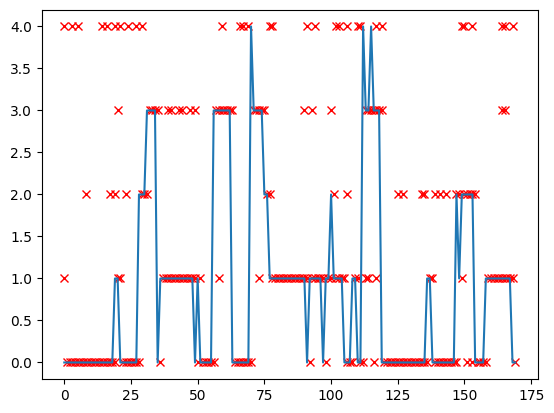

In [67]:
from Methods import *
N = 300

True_count = 0
Pred_set_size_count = 0
ITER = 170 #Setting it to 170 yields the last 6 months predictions

Punjab_True_state_vec = []

Punjab_PREDICTIONS = []
for t in np.arange(ITER):
    X=np.array([int(i) for i in df.State[1+t:N+t].tolist()])
    Y=np.array([int(i) for i in df.Observation[1+t:N+t].tolist()])
    X_pred = np.array([int(i) for i in df.State[N+t:N+t+1].tolist()])
    Y_pred = np.array([int(i) for i in df.Observation[N+t:N+t+1].tolist()])
    calX_LEN = LEN
    calY_LEN = LEN
    ALPHA = 0.8
    PERF = 0
    
    (True_state,pred_set) = CP_HMM_filtering(X, Y, X_pred, Y_pred, ALPHA, calX_LEN, calY_LEN, perf = PERF)
    Punjab_True_state_vec.append(True_state)


    for pred in pred_set:
        plt.plot(t,pred, c='r', marker = 'x', markerfacecolor='none')
        Punjab_PREDICTIONS.append((t,pred[0]))
        
    True_count += (True_state in pred_set)
    Pred_set_size_count += len(pred_set)
    
plt.plot(Punjab_True_state_vec)    
print("Coverage = " + str(True_count/len(np.arange(ITER))))
print("Avg pred set size = " + str((Pred_set_size_count/len(np.arange(ITER)))/calX_LEN))

# Visualizing the results in the same plot

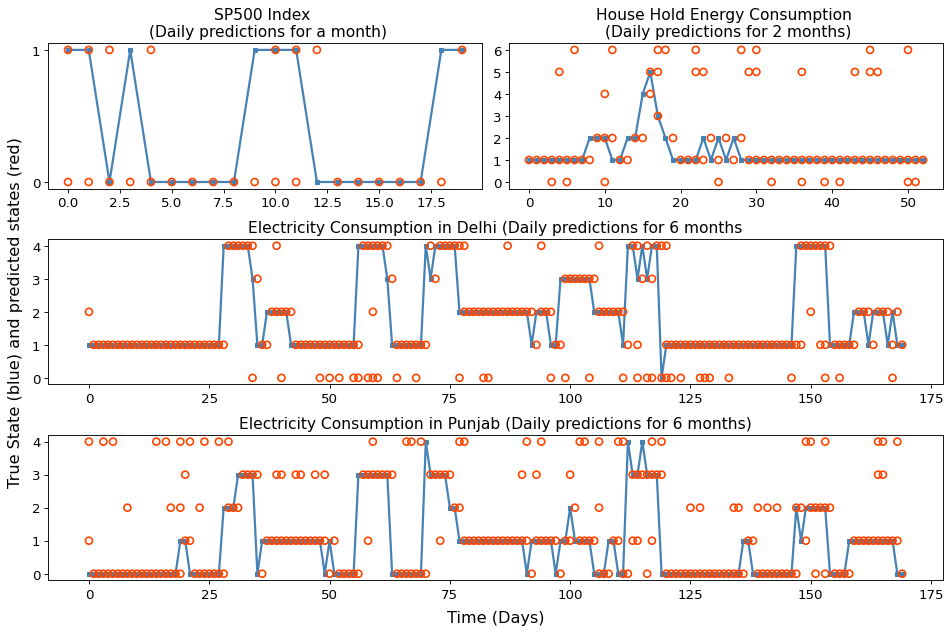

In [68]:
import matplotlib.pyplot as plt

# Parameters of figures
plt.rcParams["mathtext.fontset"]
fig = plt.figure(figsize=(12, 8), dpi=80)

gs = fig.add_gridspec(3,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])
ax4 = fig.add_subplot(gs[2, :])

ax1.plot(SPY_True_state_vec, c='steelblue', linestyle = '-', marker = 's', markersize = 4, linewidth=2, zorder=0, label = r'Desired coverage $1-\alpha = 0.8$')
ax1.scatter(*zip(*SPY_PREDICTIONS), edgecolor='orangered', marker = 'o', s = 40, linewidth=1.5, facecolors='none', zorder=0, label = r'Desired coverage $1-\alpha = 0.8$')  
ax1.set_title("SP500 Index \n (Daily predictions for a month)" , fontsize = 14)
ax1.set_yticks([0,1])
ax1.tick_params(axis='both', which='major', labelsize=12)
            
ax2.plot(D202_True_state_vec, c='steelblue', linestyle = '-', marker = 's', markersize = 4, linewidth=2, zorder=0, label = r'Desired coverage $1-\alpha = 0.8$')
ax2.scatter(*zip(*D202_PREDICTIONS), edgecolor='orangered', marker = 'o', s = 40, linewidth=1.5, facecolors='none', zorder=0, label = r'Desired coverage $1-\alpha = 0.8$')  
ax2.set_title("House Hold Energy Consumption \n (Daily predictions for 2 months)" , fontsize = 14)
ax2.set_yticks([0,1,2,3,4,5,6])
ax2.tick_params(axis='both', which='major', labelsize=12)

ax3.plot(Delhi_True_state_vec, c='steelblue', linestyle = '-', marker = 's', markersize = 4, linewidth=2, zorder=0, label = r'Desired coverage $1-\alpha = 0.8$')
ax3.scatter(*zip(*Delhi_PREDICTIONS), edgecolor='orangered', marker = 'o', s = 40, linewidth=1.5, facecolors='none', zorder=0, label = r'Desired coverage $1-\alpha = 0.8$')  
ax3.set_title("Electricity Consumption in Delhi (Daily predictions for 6 months" , fontsize = 14)
ax3.set_ylabel('True State (blue) and predicted states (red)', fontsize = 14.5, labelpad=8)
ax3.tick_params(axis='both', which='major', labelsize=12)

ax4.plot(Punjab_True_state_vec, c='steelblue', linestyle = '-', marker = 's', markersize = 4, linewidth=2, zorder=0, label = r'Desired coverage $1-\alpha = 0.8$')
ax4.scatter(*zip(*Punjab_PREDICTIONS), edgecolor='orangered', marker = 'o', s = 40, linewidth=1.5, facecolors='none', zorder=0, label = r'Desired coverage $1-\alpha = 0.8$')  
ax4.set_title("Electricity Consumption in Punjab (Daily predictions for 6 months)" , fontsize = 14)
ax4.set_xlabel(r'Time (Days)', fontsize = 14.5, labelpad=8)
ax4.tick_params(axis='both', which='major', labelsize=12)

fig.tight_layout(pad=1)

plt.savefig('All_Empirical_Results' + '.pdf', bbox_inches='tight')                                      
